# Serverless Neural Network Codebook: 2-Layer Sample
## Architecture Overview

The **“Serverless Neural Network”** is a solution for generating a Cloud Native image classifier, using idempotent Amazon Web Services ([AWS](https://aws.amazon.com/what-is-aws/)) Lambda Functions. The **"SNN"** is used to train a model to predict whether a particular image is a **“cat”** vs. **“non-cat”** and fits within an overall prediction pipeline as the model training process. The primary objective of using Lambda Functions as opposed to other services like **SageMaker** or dedicated Machine Leaning Frameworks like **MXNet **or ** TensorFlow**, is to remove the abstraction layer that inevitably perpetuates the concept that Neural Networks or Deep Learning is a “black box” architecture and thus somewhat difficult to understand.

<img src="images/Prediction_Architecture.png" style="width:800px;height:500px;">
<caption><center>**Machine Learning Pipeline**</center></caption><br>

By simulating the individual Neurons and the mathematical functions they perform, it's easier to learn the exactly what each neuron is doing and how they contribute to optimizing (or “learning”) the overall hyper-parameters used for the final prediction model. Additionally, leveraging this framework for model training will hopefully provide a more in-depth understanding of how each neuron deals with the "vectorized" matrix calculations during Forward Propagation process **AND** the gradient derivative calculations during the Backward Propagation process.

## Neural Network Overview

<img src="images/2layerNN_kiank.png" style="width:800px;height:500px;">
<caption><left>[*image source](https://www.deeplearning.ai)</left></caption><br>

The Neural Network Model (shown above) can be summarized as:
  
**INPUT --> LINEAR/RELU --> LINEAR/SIGMOID --> OUTPUT**  

- The **Input** is a $(64, 64, 3)$ image what is flattened to a vector $(12288, 1)$. See the **Data Overview** Section.
- The corresponding vector: $[x_{0}, x_{1}, \dots, x_{12287}]^T$ is then multiplied by the **weight matrix** $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- The **bias** term is then added to take the **Relu** (non-linear activation) to get a vector of size $[a^{[1]}_0, a^{[2]}_1, \dots, a^{[1]}_{n^{[1]}-1}]^T$.
- The process is then repeated for the next layer, by taking the resulting vector and multiplying it by the weight matrix $W^{[2]}$ and then adding the intercept (**bias**).
- Lastly, the **sigmoid** activation is applied to the result. If the result is greater then $0.5$, it is classified as a **Cat**.

Therefore, the **Network Model Parameters** (*parameters.json*) for the above process are as follows:

```json
{
    "epochs": 10,
    "layers": 2,
    "activations": {
        "layer1": "relu",
        "layer2": "sigmoid"
    },
    "neurons": {
        "layer1": 3,
        "layer2": 1
    },
    "learning_rate": 0.0075
}
```

## Neural Network Implementation
To implement the Neural Network using the **SNN** framework and the above Network configuration, the workflow is comprised of five key steps:  
1. Network Initialization.
2. Forward Propagation.
3. Calculate the Loss (Cost Function).
4. Backward Propagation.
5. Parameter Optimization (Gradient Descent).

The outcome of the above stages provides the optimal model parameters, for use in final prediction, as can be seen in the process diagram below.  

<img src="images/final_outline.png" style="width:800px;height:500px;">
<caption><left>[*image source](https://www.deeplearning.ai)</left></caption><br>

The next sections will further describe each phase in more detail.

### Network Initialization
For an **L-Layer** network, the *Weights* and *Bias* must be initialized for each individual layer, therefore the dimensions for these matrices must match to the dimensions of each layer. For example, if $n^{[l]}$ is the number of hidden units (neurons) in layer $l$ and the size of the input $X$ is $(12288, 209)$, for $m = 209$ training examples, then:


|               	|      **Shape of W**      	|  **Shape of b**  	|                 **Activation**                	| **Shape of Activation** 	|
|---------------	|:------------------------:	|:----------------:	|:---------------------------------------------:	|:-----------------------:	|
| **Layer 1**   	| $(n^{[1]},12288)$        	| $(n^{[1]},1)$    	| $Z^{[1]} = W^{[1]},X + b^{[1]}$               	| $(n^{[1]},209)$         	|
| **Layer 2**   	| $(n^{[2]}, n^{[1]})$     	| $(n^{[2]},1)$    	| $Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$         	| $(n^{[2]}, 209)$        	|
| $\vdots$      	| $\vdots$                 	| $\vdots$         	| $\vdots$                                      	| $\vdots$                	|
| **Layer L-1** 	| $(n^{[L-1]}, n^{[L-2]})$ 	| $(n^{[L-1]}, 1)$ 	| $Z^{[L-1]} =,W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ 	| $(n^{[L-1]}, 209)$      	|
| **Layer L**   	| $(n^{[L]}, n^{[L-1]})$   	| $(n^{[L]}, 1)$   	| $Z^{[L]} =,W^{[L]} A^{[L-1]} + b^{[L]}$       	| $(n^{[L]}, 209)$        	|


When we compute $W X + b$ in python, it carries out broadcasting. For example, if:  

$$
W = \begin{bmatrix}
j  & k  & l \\\
m  & n & o  \\\
p  & q & r
\end{bmatrix}
\space
\space
X = \begin{bmatrix}
a  & b  & c \\\
d  & e & f \\\
g  & h & i 
\end{bmatrix}
\space
\space
b =\begin{bmatrix}
s  \\\
t  \\\
u
\end{bmatrix}$$

Then $WX + b$ will be:

$$
WX + b = \begin{bmatrix}
(ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\\
(ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\\
(pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$$

To start the initialization process, the *Weights* are initialized randomly using a "standard" normal distribution with a mean of $0$ and a standard deviation of $1$. To further constrain the weights to be close to zero **but** not exactly zero (for *symmetry breaking*), each random weight is multiplied by $0.01$. The *Bias* is initialized to zero but also multiplied by $0.01$.

### Forward Propagation
The *Forward Propagation* step of the process is comprised of two separate pieces, the **Linear** activation and the **Non-Linear** activation to constrain the outputs between $0$ and $1$.  

#### Linear Activation
The *Linear* part of the activation computes the following equation:  
$$Z^{[l]} = W^{[l]} \cdot A^{[l]} + b^{[l]}$$

>**Note:** It is important to cache the Linear Activations ($Z$) for later use in he Backward Propagation process.

Where $A^{[0]} = X$

#### Non-Linear Activation
The **L-Layer** Neural Network implements two differnt non-linear activation functions:  

- **Rectified Linear Unit (ReLU):** The mathematical formula for the *ReLU* function is $A = ReLU(Z) = max(0, Z)$.  
- **Sigmoid:** The methematical formula for the *Sigmoid* function is $\sigma(Z) = \sigma(W\cdot A+b) = \frac{1}{1 + e^{(-z)}}$.  

### Loss
**Cross Entropy** is commonly-used in binary classification (labels are assumed to take values $0$ or $1$) as a loss function which is computed by:

$$\mathcal{L} = -\frac{1}{m} \sum\limits_{i = 1}^{m} \big[y^{(i)}\cdot\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\cdot\log\left(1-a^{[L](i)}\right)\big]$$

Where $a^{[L](i)}$ is the last layer of the network and is synonymous with $\hat{y}$.

Cross entropy measures the divergence between two probability distribution, if the cross entropy is large, which means that the difference between two distribution is large, while if the cross entropy is small, which means that two distribution is similar to each other. Generally, comparing to quadratic cost function, cross entropy cost function has the advantages that fast convergence and is more likely to reach the global optimization. For the mathematical details, see [wikipedia](https://en.wikipedia.org/wiki/Cross_entropy).

### Backward Propagation
*Backward Propagation* is used to calculate the the gradient of the *Loss* function with respect to the various paramaters, as follows:

<img src="images/backprop_kiank.png" style="width:800px;height:500px;">
<caption><left>[*image source](https://www.deeplearning.ai)</left></caption><br>

#### Non-Linear Derivative
As with *Forward Propagation*, there are two derivative non-linear activation functions for *Sigmoid* and *ReLU* respectively. If $g(\cdot)$ is the activations function, then the derivative of *Sigmoid* and *ReLU* compute:
$$dZ^{[l]} = \frac{\partial\mathcal{L}}{\partial Z^{[l]}} = dA^{[l]} \cdot g^{'}(Z^{[l]})$$

#### Linear Derivative
Once the derivative of the non-linear activation is computed, the derivatives of $W^{[l]}$, $b^{[l]}$ and $A^{[l]}$, are computed using the input $dZ^{[l]}$, to get , $dW^{[l]}$, $db^{[l]}$, $dA^{[l-1]}$ as follows:

$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$  
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$  
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$  

### Parameter Update using Gradient Descent
The Model parameters ($W^{[l]}$ and $b^{[l]}$) are updated using **Gradient Descent** using the following formula:  

$$W^{[l]} = W^{[l]} - \alpha\cdot dW^{[l]}$$  
$$b^{[l]} = b^{[l]} - \alpha\cdot db^{[l]}$$  

Where $\alpha$ is the *Learning Rate*.

### Prediction
After the fitted parameters are updated using *Gradient Descent*, the paramaters can be used to predict wether a new image can classified as a **cat** or **non-cat** image. For further information on how the accuracy of the trained model fairs against testing data or unseen data, see the **Analysis** Notebook.

---
## Libraries, Global and Event Variables

The cell below imports all the packages that will be needed by the Lambda Function. 
- [datetime](https://docs.python.org/2/library/datetime.html) provides classes for manipulating dates and times in both simple and complex ways.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- [boto3](https://pypi.python.org/pypi/boto3) is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python, which allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2.
- [json](https://docs.python.org/3/library/json.html) is a lightweight data interchange format inspired by JavaScript object literal syntax (although it is not a strict subset of JavaScript.
- [os](https://docs.python.org/3/library/os.html) is a module the provides a portable way of using operating system dependent functionality. Particularly the  `environ` object is a mapping object representing the environment.
- [uuid](https://docs.python.org/2/library/uuid.html#uuid.uuid4) creates a unique, random ID.
- The [io](https://docs.python.org/2/library/io.html) module provides the Python interfaces to stream handling.
- The Python interface to the [Redis](https://pypi.python.org/pypi/redis) key-value store.

### Libraries

In [1]:
# Import Libraries needed by the Lambda Function
import datetime
import numpy as np
import h5py
import scipy
import os
from os import environ
import json
from json import dumps, loads
from boto3 import client, resource, Session
import botocore
import uuid
import io
import redis
from redis import StrictRedis as redis

# Import libraries needed for the Codebook
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 10.0)

### S3 Trigger Event
T0 initiate the network training process, the dataset (**datasets.h5**) is uploaded to Amazon Simple Storage Services ([S3](https://aws.amazon.com/s3/)). This porcess triggers the S3 bucket event wich starts the training process. A sample of the event payload sent to the SNN framework is as follows:

>**Note:** In order for the *2-Layer Sample* to work, please update the following lines in the code below and add the name of the S3 Bucket created during deployment. For example:
```json
    "bucket": {
        "arn": "arn:aws:s3:::<BUCKET Name>",
        "name": "<Bucket Name>",
    ...
```
For this version of the implementation, the S3 Bucket is called **itsacat-demo** and the folder is called **training_input**.

In [2]:
# Simulate S3 event trigger data
event = {
    "Records": [
        {
            "eventVersion": "2.0",
            "eventTime": "1970-01-01T00:00:00.000Z",
            "requestParameters": {
                "sourceIPAddress": "127.0.0.1"
             },
            "s3": {
                "configurationId": "testConfigRule",
                "object": {
                    "eTag": "0123456789abcdef0123456789abcdef",
                    "sequencer": "0A1B2C3D4E5F678901",
                    "key": "training_input/datasets.h5",
                    "size": 1024
                },
                "bucket": {
                    "arn": "arn:aws:s3:::itsacat-demo",
                    "name": "itsacat-demo",
                    "ownerIdentity": {
                        "principalId": "EXAMPLE"
                    }
                },
                "s3SchemaVersion": "1.0"
            },
            "responseElements": {
                "x-amz-id-2": "EXAMPLE123/5678abcdefghijklambdaisawesome/mnopqrstuvwxyzABCDEFGH",
                "x-amz-request-id": "EXAMPLE123456789"
            },
            "awsRegion": "us-west-2",
            "eventName": "ObjectCreated:Put",
            "userIdentity": {
                "principalId": "EXAMPLE"
            },
            "eventSource": "aws:s3"
        }
    ]
}
context = ''

To establish client connectivity to the various AWS services that the function will leverage, the following code creates the needed clients for the various AWS services, as global variables.

### Global Variables

In [3]:
# Global Variables
s3_client = client('s3', region_name='us-west-2') # S3 low level class object
s3_resource = resource('s3') # S3 high level service class
lambda_client = client('lambda', region_name='us-west-2') # Lambda invocation client
redis_client = client('elasticache', region_name='us-west-2') # ElastiCache low level object

# Find and retrieve the Elasticache Cluster endpoint
cc = redis_client.describe_cache_clusters(ShowCacheNodeInfo=True)
endpoint = cc['CacheClusters'][0]['CacheNodes'][0]['Endpoint']['Address']
cache = redis(host=endpoint, port=6379, db=15) # Connect Python to Redis Cluster

---
## Data Overview
### Training and Test Datasets
It is **very important** in Neural Network programming (without the use of a Deep Learning Framework), to have a full understanding of the dimensions of the input data as well as how the dimensions are transformed at each layer, therefore to build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat, the following cells explain the datsets.

To train the Neural Network, we are provided with a dataset (`datasets.h5`) containing:
- a training set of $m$ images containing cats and non-cats as well as the appropriate class labels ($y=1$) and non-cat images ($y=0$).
- a test set of $m$ images containing cats and non-cat sas well as the appropriate class labels ($y=1$) and non-cat images ($y=0$).
- classes list for cat and non-cat images.

>**Note:** The original dataset was comprised of two separate files, `test_catvnoncat.h5` and `train_catvnoncat.h5`. For the sake of this implementation a single file is needed to upload to the *S3 Bucket*, `datasets.h5`.

In [4]:
# Load main dataset that's stored locally
dataset = h5py.File('datasets/datasets.h5', "r")

# Get the names of the unique datsets
datasetNames = [n for n in dataset.keys()]
for n in datasetNames:
    print(n)

list_classes
test_set_x
test_set_y
train_set_x
train_set_y


In [5]:
# Create numpy arrays of the various unique datasets
train_set_x_orig = np.array(dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(dataset["train_set_y"][:]) # train set labels
test_set_x_orig = np.array(dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(dataset["test_set_y"][:]) # test set labels
classes = np.array(dataset["list_classes"][:]) # the list of classes

In [6]:
# Displaye the dimensions of each unique data set
print("train_set_x_orig dimensions: " + str(train_set_x_orig.shape))
print("train_set_y_orig dimension: " + str(train_set_y_orig.shape))
print("test_set_x_orig dimensions: " + str(test_set_x_orig.shape))
print("test_set_y_orig dimensions: " + str(test_set_y_orig.shape))
test_set_y_orig

train_set_x_orig dimensions: (209, 64, 64, 3)
train_set_y_orig dimension: (209,)
test_set_x_orig dimensions: (50, 64, 64, 3)
test_set_y_orig dimensions: (50,)


array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0])

From the cell above, the image data (`train_set_x_orig` and `test_set_x_orig`) are 4-dimensional arrays consiting of $209$ training examoples (**m_train**) and $50$ testing images (**m_test**) respectively. Each image is in turn of *height*, *width* and *depth* (**R**ed, **G**reen **B**lue values) of $64 \times 64 \times 3$.

Additionally, the dimension for the labels (`train_set_y_orig` and `test_set_y_orig`) only show a $209$ and $50$ column structure. So it is recommended when coding new networks, don't use data structures where the shape is $5$, or $n$, rank 1 array. Instead, this is set to, `(1, 209)` and `(1, 50)`, to make them a **row vector**, and in essence add another dimension to the `Numpy` array.

In [7]:
# Create row vectors for the labels.
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

In [8]:
print("train_set_y dimensions: " + str(train_set_y.shape))
print("test_set_y dimensions: " + str(test_set_y.shape))
test_set_y

train_set_y dimensions: (1, 209)
test_set_y dimensions: (1, 50)


array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])

>**Note:** Now that the additional dimension has been added to the label data, we can note the additional "[[ ]]" when displaying the array.

Next we can see the label data and view the corresponding image, in this case, $index = 2$.

y = [1], and therefore it's a 'cat' picture.


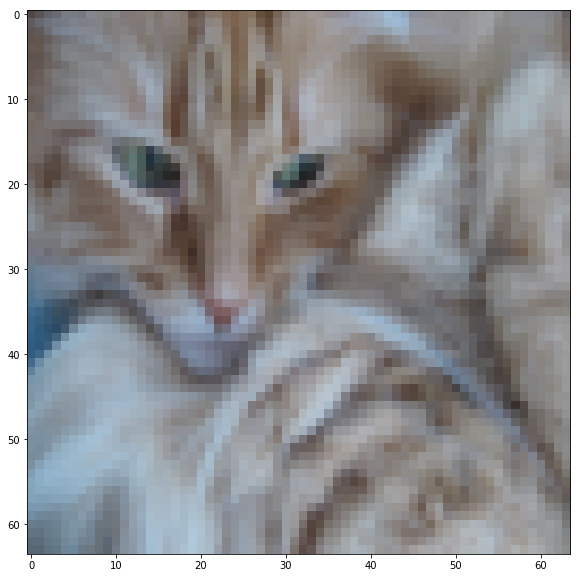

In [9]:
# Example of a cat picture
index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + \
       ", and therefore it's a '" + \
       classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + \
       "' picture.")

The `np.squeeze()` method extracts the " inner dimension" of the array, for example:

In [10]:
train_set_y[:, index]

array([1])

In [11]:
np.squeeze(train_set_y[:, index])

array(1)

>**Note:** The "[ ]" has been removed.

### Data Preprocessing
The final model analysis (see **Analysis** Notebook)is expecting a *training* set and a *test* set represented by a numpy array of shape (no. pixels $\times$ no. pixels $\times$ depth, data set size) respectively. In turn, the model is expecting the training set and test set labels represented as a numpy array (vector) of shape (1, data set size) respectively.

>**Note:** It is not determined as yet wether the "vectorization" of the images should be performed by the `TrainerLambda` to set up the inputs for *Layer 0*. For the sake of Version 1.0, the preprocessing of the input data will be performed by `launch.py` as various helper functions.

#### Vectorize
The images are represented by a 3D array of shape $(length, height, depth = 3)$. However, when an image is read as the input of an algorithm it is converted to a vector of shape $(length*height*3, 1)$. In other words, it is "unrolled", "flattened" or "reshaped" from a 3D array into a 1D vector as can be seen below.

<img src="images/vectorization.png" style="width:800px;height:500px;">
<caption><left>[*image source](https://www.deeplearning.ai)</left></caption><br>

The following cells explains of this process using the `train_set_x_orig` numpy array. The end result for the input to the model is a is a numpy array where where each column represents a flattened image in a matrix with all the input features (images) being a column, $209$ for the training set and $50$ for the test set respectively.

In [12]:
# Copy of origional training set
orig = train_set_x_orig
print("Original shape: " + str(orig.shape))

# "vectorize" or flatten out the array into an 1D vector
flatten = orig.reshape(orig.shape[0], -1)
print("Flattened shape: "+ str(flatten.shape))

# Transpose into a colums
flatten_T = flatten.T
print("Transpose: " + str(flatten_T.shape))

Original shape: (209, 64, 64, 3)
Flattened shape: (209, 12288)
Transpose: (12288, 209)


>**Note:** For further intuition of what the above code is doing, the following shows a more "manual", alternate way.

#### Standardize
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from $0$ to $255$. One common preprocessing step in machine learning is to subtract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by $255$ (the maximum value of a pixel channel). 

>**Note:** During the training of the model, the weights are multiplied and biases added to the initial inputs in order to observe neuron activations. Then it will backward propagate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. 

In [13]:
# Load datsets for preprocessing after vectorization
train_set_x = (train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T) / 255
test_set_x = (test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T) / 255
print("train_set_x shape: " + str(train_set_x.shape))
print("sample value: " + str(train_set_x[index][index]))

train_set_x shape: (12288, 209)
sample value: 0.266666666667


---
## Function Overview

### Helper Functions

#### `to_cache(endpoint, obj, name)`  

Serializes multiple data type to ElastiCache and returns the Key.  


In [14]:
def to_cache(endpoint, obj, name):
    """
    Serializes multiple data type to ElastiCache and returns
    the Key.
    
    Arguments:
    endpoint -- The ElastiCache endpoint
    obj -- the object to srialize. Can be of type:
            - Numpy Array
            - Python Dictionary
            - String
            - Integer
    name -- Name of the Key
    
    Returns:
    key -- For each type the key is made up of {name}|{type} and for
           the case of Numpy Arrays, the Length and Width of the 
           array are added to the Key.
    """
    
    # Test if the object to Serialize is a Numpy Array
    if 'numpy' in str(type(obj)):
        array_dtype = str(obj.dtype)
        if len(obj.shape) == 0:
            length = 0
            width = 0
        else:
            length, width = obj.shape
        # Convert the array to string
        val = obj.ravel().tostring()
        # Create a key from the name and necessary parameters from the array
        # i.e. {name}|{type}#{length}#{width}
        key = '{0}|{1}#{2}#{3}'.format(name, array_dtype, length, width)
        # Store the binary string to Redis
        cache = redis(host=endpoint, port=6379, db=15)
        cache.set(key, val)
        return key
    # Test if the object to serialize is a string
    elif type(obj) is str:
        key = '{0}|{1}'.format(name, 'string')
        val = obj
        cache = redis(host=endpoint, port=6379, db=15)
        cache.set(key, val)
        return key
    # Test if the object to serialize is an integer
    elif type(obj) is int:
        key = '{0}|{1}'.format(name, 'int')
        # Convert to a string
        val = str(obj)
        cache = redis(host=endpoint, port=6379, db=15)
        cache.set(key, val)
        return key
    # Test if the object to serialize is a dictionary
    elif type(obj) is dict:
        # Convert the dictionary to a String
        val = json.dumps(obj)
        key = '{0}|{1}'.format(name, 'json')
        cache = redis(host=endpoint, port=6379, db=15)
        cache.set(key, val)
        return key
    else:
        print(str(type(obj)) + "is not a supported serialization type")

#### `from_cache(endpoint, key)`
De-serializes binary object from ElastiCache by reading the type of object from the name and converting it to the appropriate data type.

In [15]:
def from_cache(endpoint, key):
    """
    De-serializes binary object from ElastiCache by reading
    the type of object from the name and converting it to
    the appropriate data type
    
    Arguments:
    endpoint -- ElastiCache endpoint
    key -- Name of the Key to retrieve the object
    
    Returns:
    obj -- The object converted to specifed data type
    """
    
    # Check if the Key is for a Numpy array containing
    # `float64` data types
    if 'float64' in key:
        cache = redis(host=endpoint, port=6379, db=15)
        val = cache.get(key)
        # De-serialize the value
        array_dtype, length, width = key.split('|')[1].split('#')
        if int(length) == 0:
            obj = np.float64(np.fromstring(val))
        else:
            obj = np.fromstring(val, dtype=array_dtype).reshape(int(length), int(width))
        return obj
    # Check if the Key is for a Numpy array containing
    # `int64` data types
    elif 'int64' in key:
        cache = redis(host=endpoint, port=6379, db=15)
        val = cache.get(key)
        # De-serialize the value
        array_dtype, length, width = key.split('|')[1].split('#')
        obj = np.fromstring(val, dtype=array_dtype).reshape(int(length), int(width))
        return obj
    # Check if the Key is for a json type
    elif 'json' in key:
        cache = redis(host=endpoint, port=6379, db=15)
        obj = cache.get(key)
        return json.loads(obj)
    # Chec if the Key is an integer
    elif 'int' in key:
        cache = redis(host=endpoint, port=6379, db=15)
        obj = cache.get(key)
        return int(obj)
    # Check if the Key is a string
    elif 'string' in key:
        cache = redis(host=endpoint, port=6379, db=15)
        obj = cache.get(key)
        return obj
    else:
        print(str(type(obj)) + "is not a supported serialization type")

#### `name2str(obj, namespace)`
Converts the name of the numpy array to string.

In [16]:
def name2str(obj, namespace):
    """
    Converts the name of the numpy array to string
    
    Arguments:
    obj -- Numpy array object
    namespace -- dictionary of the current global symbol table
    
    Return:
    List of the names of the Numpy arrays
    """
    return [name for name in namespace if namespace[name] is obj]

>**Side Note**: An alternate method to *List Comprehension* is to use the `chain()` function to get the names of the Numpy arrays.  
```python
    from itertools import chain
    list(chain.from_iterable(a_names))
```

#### `vectorize()`
Reshapes (flattens) the image data to column vector.

In [17]:
def vectorize(x_orig):
    """
    Vectorize the image data into a matrix of column vectors
    
    Argument:
    x_orig -- Numpy array of image data
    
    Return:
    Reshaped/Transposed Numpy array
    """
    return x_orig.reshape(x_orig.shape[0], -1).T

#### `standardize()`
Preprocess the image data.

In [18]:
def standardize(x_orig):
    """
    Standardize the input data
    
    Argument:
    x_orig -- Numpy array of image data
    
    Return:
    Call to `vectorize()`, standardized Numpy array of image data
    """
    return vectorize(x_orig) / 255

#### `initialize_data(endpoint, parameters)`
Extracts the training and testing data from S3, flattens, standardizes and then dumps the data to ElastiCache for neurons to process as layer $a^0$.

In [19]:
def initialize_data(endpoint, parameters):
    """
    Extracts the training and testing data from S3, flattens, 
    standardizes and then dumps the data to ElastiCache 
    for neurons to process as layer a^0.
    
    Arguments:
    endpoint -- The ElastiCache endpoint
    parameters -- The initial/running parameters dictionary object
    
    Returns:
    data_keys -- Hash keys for the various numpy arrays
    input_data -- Reference for the Input data extracted for the h5 file
    dims -- Reference to the dimensions of the input data
    """
    
    # Load main dataset
    dataset = h5py.File('/tmp/datasets.h5', "r")
    
    # Create numpy arrays from the various h5 datasets
    train_set_x_orig = np.array(dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(dataset["train_set_y"][:]) # train set labels
    test_set_x_orig = np.array(dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(dataset["test_set_y"][:]) # test set labels
    
    # Reshape labels
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    # Preprocess inputs
    train_set_x = standardize(train_set_x_orig)
    test_set_x = standardize(test_set_x_orig)
    
    # Create necessary keys for the data in ElastiCache
    data_keys = {} # Dictionary for the hash keys of the data set
    dims = {} # Dictionary of data set dimensions
    a_list = [train_set_x, train_set_y, test_set_x, test_set_y]
    a_names = [] # Placeholder for array names
    for i in range(len(a_list)):
        # Create a lis of the names of the numpy arrays
        a_names.append(name2str(a_list[i], locals()))
    for j in range(len(a_list)):
        # Dump the numpy arrays to ElastiCache
        data_keys[str(a_names[j][0])] = to_cache(endpoint=endpoint, obj=a_list[j], name=a_names[j][0])
        # Append the array dimensions to the list
        dims[str(a_names[j][0])] = a_list[j].shape
    
    # Initialize A0 and Y names from `train_setx` and `train_set_y`
    data_keys['A0'] = to_cache(endpoint=endpoint, obj=train_set_x, name='A0')
    data_keys['Y'] = to_cache(endpoint=endpoint, obj=train_set_y, name='Y')
    # Initialize training example size
    m = train_set_x.shape[1]
    data_keys['m'] = to_cache(endpoint, obj=m, name='m')
    
    # Multiple layer weight and bias initialization
    for l in range(1, parameters['layers']+1):
        if l == 1:
            W = np.random.randn(parameters['neurons']['layer'+str(l)], train_set_x.shape[0]) / np.sqrt(train_set_x.shape[0])
        else:
            W = np.random.randn(parameters['neurons']['layer'+str(l)], parameters['neurons']['layer'+str(l-1)]) / np.sqrt(parameters['neurons']['layer'+str(l-1)])
        b = np.zeros((parameters['neurons']['layer'+str(l)], 1))
        # Store the initial weights and bias in ElastiCache
        data_keys['W'+str(l)] = to_cache(endpoint=endpoint, obj=W, name='W'+str(l))
        data_keys['b'+str(l)] = to_cache(endpoint=endpoint, obj=b, name='b'+str(l))
    
    # Initialize the results tracking object
    results = {}
    results['Start'] = str(datetime.datetime.now())
    data_keys['results'] = to_cache(endpoint, obj=results, name='results')

    return data_keys, [j for i in a_names for j in i], dims

#### `numpy2s3(array, name, bucket)`
Serialize a Numpy array to S3 without using local copy

In [20]:
def numpy2s3(array, name, bucket):
    """
    Serialize a Numpy array to S3 without using local copy
    
    Arguments:
    array -- Numpy array of any shape
    name -- filename on S3
    bucket -- S3 Bucket name
    """
    f_out = io.BytesIO()
    np.save(f_out, array)
    try:
        s3_client.put_object(Key=name, Bucket=bucket, Body=f_out.getvalue(), ACL='bucket-owner-full-control')
    except botocore.exceptions.ClientError as e:
        print(e)

#### `start_epoch(epoch, layer, parameter_key)`
Starts a new epoch and configures the necessary state tracking objects.

In [21]:
def start_epoch(epoch, layer, parameter_key):
    """
    Starts a new epoch and configures the necessary state tracking objcts.
    
    Arguments:
    epoch -- Integer representing the "current" epoch.
    layer -- Integer representing the current hidden layer.
    """

    # Initialize the results object for the new epoch
    parameters = from_cache(endpoint=endpoint, key=parameter_key)
    
    # Add current epoch to results
    epoch2results = from_cache(endpoint=endpoint, key=parameters['data_keys']['results'])
    epoch2results['epoch' + str(epoch)] = {}
    parameters['data_keys']['results'] = to_cache(endpoint=endpoint, obj=epoch2results, name='results')
   
    # Update parameters with this functions data
    parameters['epoch'] = epoch
    parameters['layer'] = layer
    parameter_key = to_cache(endpoint=endpoint, obj=parameters, name='parameters')
    
    # Start forwardprop
    propogate(direction='forward', epoch=epoch, layer=layer+1, parameter_key=parameter_key)

#### `end(parameter_key)`
Finishes the oveall training sequence and saves the "optmized" weights and bias to S3, for the prediction aplication.

In [22]:
def end(parameter_key):
    """
    Finishes the overall training sequence and saves the "optimized" 
    weights and bias to S3, for the prediction application.
    
    Arguments:
    parameter_key -- The ElastiCache key for the current set of state parameters.
    """
    
    # Get the latest parameters
    parameters = from_cache(
        endpoint=endpoint,
        key=parameter_key
    )

    # Get the results key
    final_results = from_cache(
        endpoint=endpoint,
        key=parameters['data_keys']['results']
    )
    
    # Add the end time to the reuslts
    final_results['End'] = str(datetime.datetime.now())
    
    # Upload the final results to S3
    bucket = parameters['s3_bucket']
    results_obj = s3_resource.Object(bucket,'training_results/results.json')
    try:
        results_obj.put(Body=json.dumps(final_results))
    except botocore.exceptions.ClientError as e:
        print(e)
        raise
    
    # Get the final weights and bias for each layer and upload them to S3 for
    # use by the prediction and analysis
    # Create dictionary of model parameters for prediction app
    params = {}
    for l in range(1, parameters['layers']+1):
        params['W'+str(l)] = from_cache(endpoint=endpoint, key=parameters['data_keys']['W'+str(l)])
        params['b'+str(l)] = from_cache(endpoint=endpoint, key=parameters['data_keys']['b'+str(l)])
    # Create a model parameters file for use by prediction app
    with h5py.File('/tmp/params.h5', 'w') as h5file:
        for key in params:
            h5file['/' + key] = params[key]
    # Upload model parameters file to S3
    s3_resource.Object(bucket, 'predict_input/params.h5').put(Body=open('/tmp/params.h5', 'rb'))

    print("Training Completed Successfully!")

#### `propogate(direction, epoch, layer, parameter_key)`
Determines the amount of "hidden" units based on the layer and loops through launching the necessary `NeuronLambda` functions with the appropriate state or "direction" to propagate.

In [23]:
def propogate(direction, epoch, layer, parameter_key):
    """
    Determines the amount of "hidden" units based on the layer and loops
    through launching the necessary `NeuronLambda` functions with the 
    appropriate state. Each `NeuronLambda` implements the cost function 
    OR the gradients depending on the direction.

    Arguments:
    direction -- The current direction of the propogation, either `forward` or `backward`.
    epoch -- Integer representing the "current" epoch to close out.
    layer -- Integer representing the current hidden layer.

    Note: When launching NeuronLambda with multiple hidden unit,
    remember to assign an ID, also remember to start at 1
    and not 0. for example:
    num_hidden_units = 5
    for i in range(1, num_hidden_units + 1):
        # Do stuff
    """
    
    # Get the parameters for the layer
    parameters = from_cache(endpoint=endpoint, key=parameter_key)
    num_hidden_units = parameters['neurons']['layer' + str(layer)]
    
    # Build the NeuronLambda payload
    payload = {}
    # Add the parameters to the payload
    payload['state'] = direction
    payload['parameter_key'] = parameter_key
    payload['epoch'] = epoch
    payload['layer'] = layer

    # Determine process based on direction
    if direction == 'forward':
        # Launch Lambdas to propagate forward
        # Prepare the payload for `NeuronLambda`
        # Update parameters with this function's updates
        parameters['epoch'] = epoch
        parameters['layer'] = layer
        payload['parameter_key'] = to_cache(endpoint=endpoint, obj=parameters, name='parameters')

        # Debug Statements
        #print("Starting Forward Propagation for epoch " + str(epoch) + ", layer " + str(layer))

        for i in range(1, num_hidden_units + 1):
            # Prepare the payload for `NeuronLambda`
            payload['id'] = i
            if i == num_hidden_units:
                payload['last'] = "True"
            else:
                payload['last'] = "False"
            payload['activation'] = parameters['activations']['layer' + str(layer)]
            #payloadbytes = dumps(payload)
            # Debug Statements
            #print("Payload to be sent NeuronLambda: \n" + dumps(payload, indent=4, sort_keys=True))
            neuron_handler(event=payload, context='')
        
        return
    
    elif direction == 'backward':
        # Launch Lambdas to propagate backward        
        # Prepare the payload for `NeuronLambda`
        # Update parameters with this functions updates
        parameters['epoch'] = epoch
        parameters['layer'] = layer
        payload['parameter_key'] = to_cache(endpoint=endpoint, obj=parameters, name='parameters')

        # Debug Statement
        #print("Starting Backward Propogation for epoch " + str(epoch) + ", layer " + str(layer))

        for i in range(1, num_hidden_units + 1):
            # Prepare the payload for `NeuronLambda`
            payload['id'] = i
            if i == num_hidden_units:
                payload['last'] = "True"
            else:
                payload['last'] = "False"
            payload['activation'] = parameters['activations']['layer' + str(layer)]
            payloadbytes = dumps(payload)
            # Debug statements
            #print("Payload to be sent to NeuronLambda: \n" + dumps(payload, indent=4, sort_keys=True))
            
            neuron_handler(event=payload, context='')
        
        return
    
    else:
        raise

#### `sigmoid(z)`
Computes the sigmoid of `z`.

In [24]:
def sigmoid(z):
    """
    Computes the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size

    Return:
    sigmoid(z)
    """
    return 1.0 / (1.0 + np.exp(-z))

#### `sigmoid_backward(dA, z)`
Computes the derivative of the sigmoid function, given `z`. 

In [25]:
def sigmoid_backward(dA, z):
    """
    Implement the derivative of the sigmoid function

    Arguments:
    dA -- Post-activation gradient, of any shape
    z -- Cached linear activation from Forward prop

    Returns:
    dZ -- Gradient of the Cost with respect to z
    """
    s = 1. / (1. + np.exp(-z))
    dZ = dA * s * (1 - s)
    # Debug statement
    assert(dZ.shape == z.shape)
    return dZ

#### `relu(z)`
Implements the Rectified Linear Unit function of `z`.

In [26]:
def relu(z):
    """
    Implement the ReLU function.

    Arguments:
    z -- Output of the linear layer, of any shape

    Returns:
    a -- Post-activation parameter, of the same shape as z
    """
    a = np.maximum(0, z)
    assert(a.shape == z.shape)
    return a

#### `relu_backward(dA, z)`
Implement the backward propagation for a single ReLU unit.

In [27]:
def relu_backward(dA, z):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- Post-activation gradient, of any shape
    z -- Cached linear activation from Forward propagation

    Returns:
    dz -- Gradient of the cost with respect to z
    """
    dz = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dz[z <= 0] = 0
    assert (dz.shape == z.shape)
    return dz

#### `vectorizer(Outputs, Layer)`

In [28]:
def vectorizer(Outputs, Layer):
    """
    Creates a matrix of the individual neuron output for better vectorization
    
    Arguments:
    Outputs -- ElastiCache key to search for the data from `NeuronLambda`
               e.g. 'a' for activations; 'dw' for Weight Derivatives
    Layer -- Layer to search for neuron output that need to vectorized
    
    Returns:
    result -- Matrix matching the size for the entire layer
    """
    # Use the following Redis command to ensure a pure string is return for the key
    r = redis(host=endpoint, port=6379, db=15, charset="utf-8", decode_responses=True)
    search_results = []
    # Compile a list of all the neurons in the search layer based on the search criteria
    for n in range(1, parameters['neurons']['layer'+str(Layer)]+1):
        tmp = r.keys('layer'+str(Layer)+'_'+str(Outputs)+'_'+str(n)+'|*')
        search_results.append(tmp)
    # Created an ordered list of neuron data keys
    key_list = []
    for result in search_results:
        key_list.append(result[0])
    # Create a dictionary of neuron data
    Dict = {}
    for data in key_list:
        Dict[data] = from_cache(endpoint=endpoint, key=data)
    # Number of Neuron Activations for the search layer
    num_neurons = parameters['neurons']['layer'+str(Layer)]
    # Create a numpy array of the results, depending on the number
    # of neurons (a Matrix of Activations)
    result = np.array([arr.tolist() for arr in Dict.values()])
    if num_neurons == 1:
        # Single Neuron Activation
        dims = (key_list[0].split('|')[1].split('#')[1:])
        result = result.reshape(int(dims[0]), int(dims[1]))
    else:
        # Multiple Neuron Activations
        result = np.squeeze(result)
    
    return result

### Lambda Handler Functions
#### `launch_handler(event, context)`
This `lambda_handler()` is triggered by the S3 event where training data is uploaded to S3. It further initializes the various components needed, such as:
1. State tracking Objects:
    - Overall Results (Cost) for each Epoch.
    - Gradients for each layer.
    - Initial and updated Weight parameter for each layer.
    - Initial and updated Bias parameter for each layer.
2. DynamoDB Storage:
    - Invocation ID for each Lambda Function invocation to prevent duplicate invocation.
    >**Note:** The DynamoDB Initialization is **NOT** recorded within the **Codebook**.
3. Preprocessing the Input Data: 
    - Read in the the initial *training*, *test* of Cat and Non-cat images.
    - The function initially loads the data in `h5py` format and extracts the *training* and *test* data.
    - The function further performs any standardization and normalization of the input data.
    - The function also "*flattens*" the data into a column vector, thus performing **Vectorization**.
    - This data is dumped to ElastiCache and will thus serve as **Layer 0** of the Neural Network.
4. Environment and State Tracking Variables:
    - Loading the initial Neural Network Parameters (`parameters.json`) and augmenting these parameter with the state variables during the training process. The settings include overall parameters used by the `trainer` and `neuron` Lambda Functions, such as:
        - Total number of epochs/iterations.
        - Total number of layers in the Neural Network (including the Output layer).
        - Total number of "neurons" in each layer.
        - The activation function to be used for each layer.
    - Initializing the **Hash Keys** for the various data sets in ElastiCache to be used by the subsequent functions to get access to the numpy arrays.

In [29]:
def launch_handler(event, context):
    # Retrieve datasets and setting from S3
    input_bucket = s3_resource.Bucket(str(event['Records'][0]['s3']['bucket']['name']))
    dataset_key = str(event['Records'][0]['s3']['object']['key'])
    settings_key = dataset_key.split('/')[-2] + '/parameters.json'
    try:
        input_bucket.download_file(dataset_key, '/tmp/datasets.h5')
        #input_bucket.download_file(settings_key, '/tmp/parameters.json')
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == '404':
            print("Error downloading input data from S3, S3 object does not exist")
        else:
            raise
    
    # Extract the neural network parameters
    with open('datasets/sample_parameters.json') as parameters_file:
        parameters = json.load(parameters_file)
    
    # Build in additional neural network parameters
    # Input data sets and data set parameters
    parameters['s3_bucket'] = event['Records'][0]['s3']['bucket']['name']
    parameters['data_keys'],\
    parameters['input_data'],\
    parameters['dims'] = initialize_data(
        endpoint=endpoint,
        parameters=parameters
    )
    
    # Initialize payload to `TrainerLambda`
    payload = {}
    # Initialize the overall state
    payload['state'] = 'start'
    # Dump the parameters to ElastiCache
    payload['parameter_key'] = to_cache(endpoint, obj=parameters, name='parameters')
    #payload['endpoint'] = endpoint
    # Prepare the payload for `TrainerLambda`
    #payloadbytes = dumps(payload)
    
    # Debug statements
    print("Complete Neural Network Settings: \n")
    print(dumps(parameters, indent=4, sort_keys=True))
    print("Payload to be sent to TrainerLambda: \n" + dumps(payload, indent=4, sort_keys=True))
    trainer_handler(event=payload, context='')

    return

#### `trainer_handler(event, context)`
This `lambda_handler()` function is the most critical function in the set in that it:
1. Tracks and updates the state across the interactions/epochs and the various layers of the Neural Network.
2. Performs Vectorization on the Activation Row Vectors from each Neuron to create a *Matrix* of Activations.
3. Launches the various Neurons (`NeuronLamabda`) in each layer and tracks their output for *Forward* or *Backward* propogation.
4. Calculates the *Cost* for each iteration of *Forward* propagation.
5. Performs *Gradient Descent* for each Epoch.

In order to accomplish this, the `TrainerLambda` has three possible states, `start`, `forward` and `backward`:
1. `start`: This state starts the initial or subsequent training epochs and performs the following:
    - Initializes the new weights and bias for the epoch.
    - Updates the state table with these values.
2. `forward`: This state processes the *forward* propagation step and launches the various hidden layer Neurons and supplies the necessary state information to these functions, such as:
    - Input/Activation data location
    - Weights and Bias.
    - Hidden Layer No.
    - Number of Hidden Units.
    - Activation Funciton for the Layer.
3. `backward`: This state processes the *back* propagation step and launches the various hidden layer Neurons as well as supplies the necessary information for these functions, like:
    - Hidden Layer No.
    - Number of Hidden Units.
    - Current and previous Activations calculated from the forward propagation step.

In [30]:
def trainer_handler(event, context):
    """
    1. Processes the `event` variables from the various Lambda functions that call it, 
        i.e. `TrainerLambda` and `NeuronLambda`.
    2. Determines the "current" state and then directs the next steps.
    3. Performs Vectorization from the NeuronLambda forward propagation outputs.
    4. Calculates the Cost.
    5. Performs Gradient Descent given the gradients from the backward propagation outputs.
    """
    # Get the current state from the invoking lambda
    state = event.get('state')
    global parameters
    parameters = from_cache(endpoint=endpoint, key=event.get('parameter_key'))
    
    # Execute appropriate action based on the the current state
    if state == 'forward':
        # Perform vectorization to create a matrix of activations and/or calculate the Cost
        # Get important state variables
        epoch = event.get('epoch')
        layer = event.get('layer')

        # Get the Vectorized matrix of Activations
        A = vectorizer(Outputs='a', Layer=layer-1)

        # Add the `A` Matrix to `data_keys` for later Neuron use
        A_name = 'A' + str(layer-1)
        parameters['data_keys'][A_name] = to_cache(endpoint=endpoint, obj=A, name=A_name)

        # Update ElastiCache with this function's data
        parameter_key = to_cache(endpoint=endpoint, obj=parameters, name='parameters')
        
        # Determine the location within forwardprop
        if layer > parameters['layers']:
            # Location is at the end of forwardprop, therefore calculate Cost
            # Get the training examples data and no. examples (`Y` and `m`)
            Y = from_cache(endpoint=endpoint, key=parameters['data_keys']['Y'])
            m = from_cache(endpoint=endpoint, key=parameters['data_keys']['m'])
            
            # Calculate the Cost
            #cost = -1 / m * np.sum(np.multiply(Y, np.log(A)) + np.multiply((1 - Y), np.log(1 - A))) #from ste-by-step
            cost = (1./m) * (-np.dot(Y, np.log(A).T) - np.dot(1 - Y, np.log(1 - A).T)) #from application
            """
            Note: The cost calculation above returns `nd.array`, therefore converting to
            type `float` for for the results upload
            """
            #cost = (-1 / m) * np.sum(Y * (np.log(A)) + ((1 - Y) * np.log(1 - A))) #from S-Layer
            cost = np.squeeze(cost)
            assert(cost.shape == ())

            # Update results with the Cost
            # Get the results object
            cost2results = from_cache(endpoint=endpoint, key=parameters['data_keys']['results'])
            # Append the cost to results object
            #cost2results['epoch' + str(epoch)]['cost'] = cost
            cost2results['epoch' + str(epoch)]['cost'] = float(cost)
            # Update results key in ElastiCache
            parameters['data_keys']['results'] = to_cache(endpoint=endpoint, obj=cost2results, name='results')

            #if epoch % 100 == 0:
                #print("Cost after epoch {0}: {1}".format(epoch, cost))
            print("Cost after epoch {}: {}".format(epoch, cost))

            # Initialize backprop
            # Calculate the derivative of the Cost with respect to the last activation
            # Ensure that `Y` is the correct shape as the last activation
            Y = Y.reshape(A.shape)
            dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
            dA_name = 'dA' + str(layer-1)
            parameters['data_keys'][dA_name] = to_cache(endpoint=endpoint, obj=dA, name=dA_name)

            # Update parameters from this function in ElastiCache
            parameter_key = to_cache(endpoint=endpoint, obj=parameters, name='parameters')

            # Start Backpropagation on NeuronLambda
            propogate(direction='backward', epoch=epoch, layer=layer-1, parameter_key=parameter_key)

        else:
            # Move to the next hidden layer for multiple layer networks
            #debug
            #print("Propagating forward onto Layer " + str(layer))
            propogate(direction='forward', epoch=epoch, layer=layer, parameter_key=parameter_key)
        
    elif state == 'backward':
        # Get important state variables
        epoch = event.get('epoch')
        layer = event.get('layer')

        # Vectorize the derivatives
        dZ = vectorizer(Outputs='dZ', Layer=layer+1)
        
        # Next pre-process the derivative of the weights
        dW = vectorizer(Outputs='dw', Layer=layer+1)
        
        # pre-process the derivatives of the bias
        db = vectorizer(Outputs='db', Layer=layer+1)
        db = db.reshape(db.shape[0], 1)
        
        # Determine the location within backprop
        if epoch == parameters['epochs']-1 and layer == 0:
            # Location is at the end of the final epoch
            # Get relavent parameters for bacprop
            W = from_cache(endpoint=endpoint, key=parameters['data_keys']['W'+str(layer+1)])
            b = from_cache(endpoint=endpoint, key=parameters['data_keys']['b'+str(layer+1)])
            learning_rate = parameters['learning_rate']
            # Run Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db

            # Update ElastiCache with the new Weights and new Bias to be used as the inputs for
            # the next epoch
            parameters['data_keys']['W'+str(layer+1)] = to_cache(
                endpoint=endpoint,
                obj=W,
                name='W'+str(layer+1)
            )
            parameters['data_keys']['b'+str(layer+1)] = to_cache(
                endpoint=endpoint,
                obj=b,
                name='b'+str(layer+1)
            )
            
            # Update parameters for the next epoch
            parameter_key = to_cache(endpoint=endpoint, obj=parameters, name='parameters')
                        
            # Finalize the the process and clean up
            end(parameter_key=parameter_key)
            
        elif epoch < parameters['epochs']-1 and layer == 0:
            # Location is at the end of the current epoch and backprop is finished
            # Get relevent parameters for backprop
            W = from_cache(endpoint=endpoint, key=parameters['data_keys']['W'+str(layer+1)])
            b = from_cache(endpoint=endpoint, key=parameters['data_keys']['b'+str(layer+1)])
            learning_rate = parameters['learning_rate']
            # Run Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db

            # Update ElastiCache with the new Weights and new Bias to be used as the inputs for
            # the next epoch
            parameters['data_keys']['W'+str(layer+1)] = to_cache(
                endpoint=endpoint,
                obj=W,
                name='W'+str(layer+1)
            )
            parameters['data_keys']['b'+str(layer+1)] = to_cache(
                endpoint=endpoint,
                obj=b,
                name='b'+str(layer+1)
            )
            
            # Update parameters for the next epoch
            parameter_key = to_cache(endpoint=endpoint, obj=parameters, name='parameters')
                        
            # Start the next epoch
            start_epoch(epoch=epoch+1, layer=0, parameter_key=parameter_key)
            
        else:
            # Location is still within the backprop process, therefore calculate 
            # the derivative of the current layer's activations with respect to the 
            # Cost as well as perform gradient decent to get and new weights and bias
            # Get relevent parameters for backprop
            W = from_cache(endpoint=endpoint, key=parameters['data_keys']['W'+str(layer+1)])
            b = from_cache(endpoint=endpoint, key=parameters['data_keys']['b'+str(layer+1)])
            learning_rate = parameters['learning_rate']
            dA = np.dot(W.T, dZ)
            dA_name = 'dA' + str(layer)
            parameters['data_keys'][dA_name] = to_cache(endpoint=endpoint, obj=dA, name=dA_name)

            # Run Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
            # Update ElastiCache with the new Weights and new Bias to be used as the inputs for
            # the next epoch
            parameters['data_keys']['W'+str(layer+1)] = to_cache(
                endpoint=endpoint,
                obj=W,
                name='W'+str(layer+1)
            )
            parameters['data_keys']['b'+str(layer+1)] = to_cache(
                endpoint=endpoint,
                obj=b,
                name='b'+str(layer+1)
            )

            # Update parameters from this function in ElastiCache
            parameter_key = to_cache(endpoint=endpoint, obj=parameters, name='parameters')

            # Move to the next hidden layer
            propogate(direction='backward', epoch=epoch, layer=layer, parameter_key=parameter_key)
            
    elif state == 'start':
        # Start training process        
        # Create initial parameters
        epoch = 0
        layer = 0
        start_epoch(epoch=epoch, layer=layer, parameter_key=event.get('parameter_key'))

#### `neuron_handler(event, context)`
This `lambda_handler()` simulates a single *Perceptron* for both forward and backward propagation. If the state is `forward` then the function simulates forward propagation for $X$ to $Cost$ for the current layer. If the state is backward, then the function calculates the gradient of the derivative of the activation function for the current layer.

>**Note:** This function also moves the state to the next or previous layer, depending on the state.

In [31]:
def neuron_handler(event, context):
    """
    This Lambda Funciton simulates a single Perceptron for both 
    forward and backward propogation.
    """    
    # Get the Neural Network parameters from Elasticache
    parameters = from_cache(endpoint, key=event.get('parameter_key'))
       
    # Get the current state
    state = event.get('state')
    epoch = event.get('epoch')
    layer = event.get('layer')
    ID = event.get('id') # To be used when multiple activations
    # Determine is this is the last Neuron in the layer
    last = event.get('last')
    activation = event.get('activation')
    # Debug Statement
    #print("Starting {} propagation on Neuron: {}, for Epoch {} and Layer {}".format(state, str(ID), str(epoch), str(layer)))

    if state == 'forward':
        # Forward propagation from A0 to Cost
        # Activations from the previous layer
        A_prev = from_cache(endpoint=endpoint, key=parameters['data_keys']['A'+str(layer - 1)])
        # Get the weights for this neuron
        w = from_cache(endpoint=endpoint, key=parameters['data_keys']['W'+str(layer)])[ID-1, :]
        # Convert weights to a row vector
        w = w.reshape(1, w.shape[0])
        # Get the bias for this neuron as row vector
        b = from_cache(endpoint=endpoint, key=parameters['data_keys']['b'+str(layer)])[ID-1, :]
        # Perform the linear part of the layer's forward propagation
        z = np.dot(w, A_prev) + b
        # Upload the linear transformation results to ElastiCache for use with Backprop
        to_cache(endpoint=endpoint, obj=z, name='layer'+str(layer)+'_z_'+str(ID))

        # Perform non-linear activation based on the activation function
        if activation == 'sigmoid':
            a = sigmoid(z)
        elif activation == 'relu':
            a = relu(z)
        else:
            # No other functions supported at this time
            pass
        # Upload the results to ElastiCache for `TrainerLambda` to vectorize
        to_cache(endpoint=endpoint, obj=a, name='layer'+str(layer)+'_a_'+str(ID))

        # Debug Statement
        #print("Completed Forward Propagation for epoch {}, layer {}".format(str(epoch), str(layer)))
        
        if last == "True":
            # Update parameters with this Neuron's data
            parameters['epoch'] = epoch
            parameters['layer'] = layer + 1
            # Build the state payload
            payload = {}
            payload['parameter_key'] = to_cache(endpoint=endpoint, obj=parameters, name='parameters')
            payload['state'] = 'forward'
            payload['epoch'] = epoch
            payload['layer'] = layer + 1

            # Debug Statement
            #print("Payload to be sent to TrainerLambda: \n" + dumps(payload, indent=4, sort_keys=True))
            
            trainer_handler(event=payload, context='')

        return

    elif state == 'backward':
        # Backprop from Cost to X (A0)
        """
        Intuition: TrainerLambda launched back prop with `layer-1`, therefore this should be 
        last "active" layer. That means that the "dA" for this layer has already been
        calculate. Thus, no need to do the `A - Y` error calculation. Additionally, 
        the following code structure makes the it more idempotent for multiple layers.
        """
        # Get necessary parameters
        r = redis(host=endpoint, port=6379, db=15, charset="utf-8", decode_responses=True)
        z_key = []
        for z in r.scan_iter(match='layer'+str(layer)+'_z_'+str(ID)+'*'):
            z_key.append(z)
        z = from_cache(endpoint=endpoint, key=z_key[0])
        m = from_cache(endpoint=endpoint, key=parameters['data_keys']['m'])
        A_prev = from_cache(endpoint=endpoint, key=parameters['data_keys']['A'+str(layer-1)])

        # Get the derivative of the current layer's activation,
        # based on the size of the layer.
        if layer == parameters['layers']:
            # If this is the last layer, then:
            dA = from_cache(endpoint=endpoint, key=parameters['data_keys']['dA'+str(layer)])
            W = from_cache(endpoint=endpoint, key=parameters['data_keys']['W'+str(layer)])
        else:
            dA = from_cache(endpoint=endpoint, key=parameters['data_keys']['dA'+str(layer)])[ID-1, :]
            dA = dA.reshape(1, dA.shape[0])
            W = from_cache(endpoint=endpoint, key=parameters['data_keys']['W'+str(layer)])[ID-1, :]
            W = W.reshape(1, W.shape[0])
        
        # Calculate the derivative of the Activations
        if activation=='sigmoid':
            dZ = sigmoid_backward(dA, z)
        elif activation == 'relu':
            dZ = relu_backward(dA, z)
        elif activaion == 'leaky_relu':
            dZ = leaky_relu_backward(dA, z)
        else:
            # No other functions supported at this time
            pass
        # Upload the derivative of the activation to ElastiCache for use by `TrainerLambda`
        to_cache(endpoint=endpoint, obj=dZ, name='layer'+str(layer)+'_dZ_'+str(ID))
        
        # Calculate the derivatives of the weights
        dw = 1 / m * np.dot(dZ, A_prev.T)
        # Upload the derivative of the weights to ElastiCache for use by `TrainerLambda`
        to_cache(endpoint=endpoint, obj=dw, name='layer'+str(layer)+'_dw_'+str(ID))
        
        # Debug statement
        assert(dw.shape == W.shape)

        # Calculate the derivatives of the bias
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True) #<-- Could be an issue here and may have to reshape in TrainerLambda when runnign backprop oin layer 1
        #db = 1 / m * np.sum(dZ)
        # Upload the derivative of the bis to ElastiCache for use by `TrainerLambda`
        to_cache(endpoint=endpoint, obj=db, name='layer'+str(layer)+'_db_'+str(ID))

        # Debug Statement
        #print("Completed Back Propogation for epoch {}, layer {}".format(str(epoch), str(layer)))

        if last == "True":
            # Update parameters with this Neuron's data
            parameters['epoch'] = epoch
            parameters['layer'] = layer - 1
            # Build the state payload
            payload = {}
            payload['parameter_key'] = to_cache(endpoint=endpoint, obj=parameters, name='parameters')
            payload['state'] = 'backward'
            payload['epoch'] = epoch
            payload['layer'] = layer - 1

            # Debug Statement
            #print("Payload to be sent to TrainerLambda: \n" + dumps(payload, indent=4, sort_keys=True))
            
            trainer_handler(event=payload, context='')
            
        return

---
## Sample Model Training
### Overview
The following demonstrates training the model for a *2-Layer* Network over $10$ Epochs. The final results are stored on S3 and can be analyzed after training has been completed.

### 1 - Trigger Event from S3
**Simulate the training data being uploaded to S3 and Launching the training process.**

In [32]:
# Simulate S3 event trigger data
launch_handler(event, context)

Complete Neural Network Settings: 

{
    "activations": {
        "layer1": "relu",
        "layer2": "sigmoid"
    },
    "data_keys": {
        "A0": "A0|float64#12288#209",
        "W1": "W1|float64#3#12288",
        "W2": "W2|float64#1#3",
        "Y": "Y|int64#1#209",
        "b1": "b1|float64#3#1",
        "b2": "b2|float64#1#1",
        "m": "m|int",
        "results": "results|json",
        "test_set_x": "test_set_x|float64#12288#50",
        "test_set_y": "test_set_y|int64#1#50",
        "train_set_x": "train_set_x|float64#12288#209",
        "train_set_y": "train_set_y|int64#1#209"
    },
    "dims": {
        "test_set_x": [
            12288,
            50
        ],
        "test_set_y": [
            1,
            50
        ],
        "train_set_x": [
            12288,
            209
        ],
        "train_set_y": [
            1,
            209
        ]
    },
    "epochs": 10,
    "input_data": [
        "train_set_x",
        "train_set_y",
        "test_se

### 2 - View the Training Results
Althoug there are only $10$ iterations of the model training process, the cost should decrease after every epoch and can be visualized as follows:

Total Processing time: 7 minutes


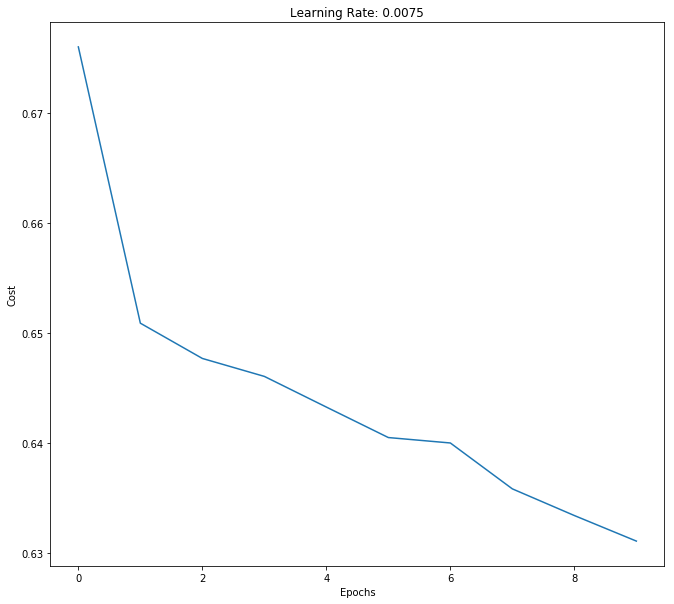

In [33]:
# View the Results object stored on S3
bucket = parameters['s3_bucket']
content = s3_resource.Object(bucket, 'training_results/results.json')
file = content.get()['Body'].read().decode('utf-8')
json_content = json.loads(file)
#print(json_content)
costs = []
for k, v in json_content.items():
    # Get the cost at each epoch
    if 'epoch' in k:
        costs.append(v.get('cost'))
    # Get the training start time
    elif 'Start' in k:
        start = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
    # Get the training end time
    else:
        end = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
delta = end - start
print("Total Processing time: {} minutes".format(int(delta.total_seconds() / 60)))
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title("Learning Rate: " + str(parameters['learning_rate']))
plt.show;

---
## Next: Full Model Training
Now that model training process (and code) can be verified, it's time to train the model using the  serverless framework. Please refer to the [**README**](../README.md) on how to start the training process and then [**Analyze**](./Analysis.ipynb) the results.